# 1 Introducción

El ejercicio 3 de la tercera evaluación de aprendizaje tomará como entrada una cadena de caracteres, contará las ocurrencias de cada palabra en la cadena, y mostrará por pantalla las 10 palabras que mas se repiten, especificando el número de veces que aparece cada una.

Para esto, compararemos el algoritmo ejecutando secuencialmente con el mismo algoritmo haciendo uso de threads mediante OPEN MP.

Para que la muestra sea considerable, se repite la cuenta de palabras 10000 veces, de manera que sea mas coherente el uso de la paralelización de tareas en el script.

El texto de entrada será obtenido desde un archivo en google drive para poder comprobar las funcionalidades y atributos que ofrece colab.



---
# 2 Armado del ambiente

## Localización de archivo de entrada
El texto de entrada que será usado para el algoritmo se aloja en un archivo de texto en google drive.  
El link es el siguiente :

**https://drive.google.com/file/d/1Lr_lIu0Ntl5V7ZrsrBtP1EqeiJMxnqjP/view?usp=sharing**

La cuenta a utilizar para acceder a este archivo es la siguiente :

> Email : **soa.colab.matias.cabre@gmail.com**  
> Password : **soacolab123**

Puede ser modificado a gusto.

Se recomienda el uso de la aplicación text editor para modificarlo desde google drive.

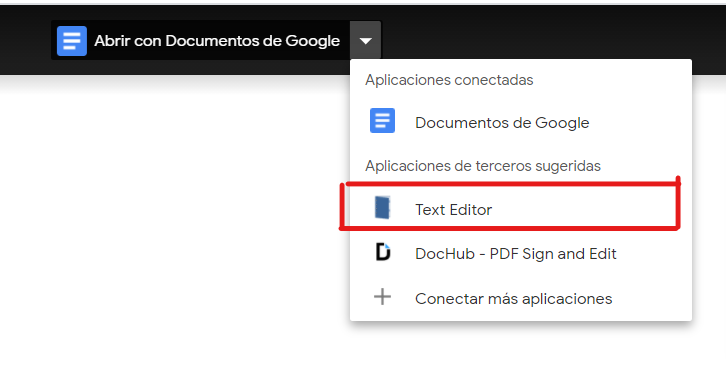


## Descarga de archivo de entrada

Una vez modificado el archivo en drive con el texto de entrada deseado, se procede a descargar el archivo a la maquina virtual local de colab para su uso.

Para esto, al ejecutar el código que se encuentra debajo, nos pedirá que accedamos a un link con la cuenta de gmail, que otorguemos los permisos que nos pide y que copiemos el código que ese link nos concede, y que lo ingresemos aquí, luego de ingresarlo debemos oprimir la tecla *enter*.

La cuenta de gmail a utilizar es la nombrada anteriormente:

> Email : **soa.colab.matias.cabre@gmail.com**  
> Password : **soacolab123**

In [ ]:
# Importación de bibliotecas necesarias
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# autenticación en google drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# descarga de archivo de entrada
file_id = '1Lr_lIu0Ntl5V7ZrsrBtP1EqeiJMxnqjP'
downloaded_file_drive = drive.CreateFile({'id': file_id})
downloaded_file_drive_text = downloaded_file_drive.GetContentString()
print('Contenido del archivo : "{}"'.format(downloaded_file_drive_text))

Contenido del archivo : "Esto es una prueba, para ver como se cuentan las palabras de estas oraciones. Estas palabras se cuentan de una en una.
Se cuentan a través de un algoritmo secuencial, y también a través de un algoritmo paralelizado."


---
# 3 Desarrollo





## OPEN MP
Ejecución del algoritmo contador de palabras secuencialmente y paralelamente con open mp.

In [ ]:
# Codigo Python, que tiene el código C de la ejecución.
code = """
// Axpy con OpenMP, usando c, ejecutado en Colab. 

#include <iostream>
#include <vector>
#include <cstdlib>
#include <sys/time.h>
#include <omp.h>    // Cabecera OpenMP   
#include <sstream>
#include <map>
#include <bits/stdc++.h> 



// ----------------------------------------------------------------------------
// Macros que miden el tiempo.

static double dHashTiempoHistory[3];
static struct timeval tv;

#define TIEMPO_INI( h )      \
   gettimeofday(&tv,NULL);   \
   dHashTiempoHistory[ h ] = tv.tv_sec + tv.tv_usec/1000000.0;
   
   
#define TIEMPO_FIN( h )      \
   gettimeofday(&tv,NULL);   \
   dHashTiempoHistory[ h ] = ((tv.tv_sec + tv.tv_usec/1000000.0) - dHashTiempoHistory[ h ]) * 1000; // Devuelvo en milisegundos
#define TIEMPO_GET( h ) dHashTiempoHistory[ h ]

#define HTH_FOR_SEQ         1
#define HTH_FOR_OPENMP      2
#define HTH_TOTAL           3

using namespace std;

// ----------------------------------------------------------------------------
// Función comparación 
bool cmp(pair<string, int>& a, 
         pair<string, int>& b) 
{ 
    return a.second > b.second; 
} 
  
//Función que ordena los elementos del map y los imprime.
void show_results(map<string, int>& M) 
{ 
  
    // Declare vector of pairs 
    vector<pair<string, int> > A; 
  
    // Copy key-value pair from Map 
    // to vector of pairs 
    for (auto& it : M) { 
        A.push_back(it); 
    } 
  
    // Sort using comparator function 
    sort(A.begin(), A.end(), cmp); 
  
    // Print the sorted value 
    cout << "**********TOP 10 palabras mas utilizadas***********" << endl;
    for (int i = 0 ; i < 10 ; i++) { 
        
        cout << A[i].first << '\t'
             << A[i].second << endl; 
    } 
    cout << "*******************FIN TOP 10**********************" << endl;
} 

int main(int argc, char* argv[]) 
{ 
  int i = 0;
  TIEMPO_INI( HTH_TOTAL )

  // Leo los parametros.
  if( argc != 2 )
  {
      std::cerr<< " Error en los parametros de indicar: (cadena de caracteres)."<<argc<<std::endl;
      exit( -1 );
  }

  string cadena_caracteres = argv[1];

  // --------------------------------------------
  // Defino la memoria de los vectores.

  stringstream ssin(cadena_caracteres);
  map<string,int> map, map_valores_reales = {};
  vector<string> vector;
 
  while (ssin.good()){
      string palabra;
      ssin >> palabra;
      vector.push_back(palabra);
      map[palabra] = 0;
      map_valores_reales[palabra] = 0;
  }

  for(int i = 0; i <vector.size(); i++){
    map_valores_reales[vector[i]]++;
  }

  TIEMPO_INI( HTH_FOR_SEQ )
  for(int j = 0 ; j < 10000; j++){
    for(int i = 0; i <vector.size(); i++){
      map[vector[i]]++;
    }
  }
  TIEMPO_FIN( HTH_FOR_SEQ )
  
  TIEMPO_INI( HTH_FOR_OPENMP )
  for(int j = 0 ; j < 10000; j++){
    #pragma omp parallel for
    for(int i = 0; i <vector.size(); i++){
      map[vector[i]]++;
    }
  }
  TIEMPO_FIN( HTH_FOR_OPENMP )
  cout << "************ Valores con cantidad de palabras real *****************" << endl;
  cout << endl;
  show_results(map_valores_reales);

  cout << endl;
  cout << "************ Valores con cantidad de palabras multiplicadas *****************" << endl;
  cout << endl;
  show_results(map);
  cout << endl;
  TIEMPO_FIN( HTH_TOTAL )

  cout << endl;
  cout << "************ TIEMPOS *****************" << endl;
  cout << "Tiempo contador palabras secuencial  : "<<TIEMPO_GET(HTH_FOR_SEQ)<<" [ms]" << endl;
  cout << "Tiempo contador palabras openmp: "<<TIEMPO_GET(HTH_FOR_OPENMP)<<" [ms]" << endl;
  cout << "Tiempo total  : "<<TIEMPO_GET(HTH_TOTAL)<<" [ms]" << endl;
  cout << "*********** FIN TIEMPOS **************";
  cout << endl << endl;

  std::cout<<"Valores Reales  :" <<std::endl;
  std::cout<<"SpeedUp          : (tiempo Secuencial/tiempo paralelo) : "<<TIEMPO_GET(HTH_FOR_SEQ)<<" / "<<TIEMPO_GET(HTH_FOR_OPENMP)<<" = "<<TIEMPO_GET(HTH_FOR_SEQ)/TIEMPO_GET(HTH_FOR_OPENMP)<<std::endl;
  std::cout<<"Eficiencia       : SpeedUp/nro procesadores            : "<<TIEMPO_GET(HTH_FOR_SEQ)/TIEMPO_GET(HTH_FOR_OPENMP)<<" / "<<omp_get_num_procs()<<" = "<<TIEMPO_GET(HTH_FOR_SEQ)/(omp_get_num_procs()*TIEMPO_GET(HTH_FOR_OPENMP))<<std::endl;
  std::cout<<"Coste Sec        : nro procesadores*Tiempo             : "<<1<<" * "<<TIEMPO_GET(HTH_FOR_SEQ)<<" = "<<TIEMPO_GET(HTH_FOR_SEQ)<<std::endl;
  std::cout<<"Coste Omp        : nro procesadores*Tiempo             : "<<omp_get_num_procs()<<" * "<<TIEMPO_GET(HTH_FOR_OPENMP)<<" = "<<omp_get_num_procs()*TIEMPO_GET(HTH_FOR_OPENMP)<<std::endl;
  std::cout<<"Funcion Overhead : Coste Omp - tiempo Secuencial       : "<<omp_get_num_procs()*TIEMPO_GET(HTH_FOR_OPENMP)<<" - "<<TIEMPO_GET(HTH_FOR_SEQ)<<" = "<<(omp_get_num_procs()*TIEMPO_GET(HTH_FOR_OPENMP))-TIEMPO_GET(HTH_FOR_SEQ)<<std::endl;
}
// ----------------------------------------------------------------------------
"""
text_file = open("code.cpp", "w")
text_file.write(code)
text_file.close()

#Compilación

In [ ]:
!g++ -o app -fopenmp code.cpp

#Ejecución

In [ ]:
import sys
try:
  downloaded_file_drive_text
except NameError:
  print("Antes de ejecutar el código descargar el archivo de entrada desde google drive, en la sección de armado del ambiente")
  sys.exit()

%env OMP_NUM_THREADS=2
!./app "$downloaded_file_drive_text"

env: OMP_NUM_THREADS=2
************ Valores con cantidad de palabras real *****************

**********TOP 10 palabras mas utilizadas***********
de	4
cuentan	3
a	2
algoritmo	2
una	2
un	2
través	2
palabras	2
se	2
y	1
*******************FIN TOP 10**********************

************ Valores con cantidad de palabras multiplicadas *****************

**********TOP 10 palabras mas utilizadas***********
de	79999
cuentan	59999
a	40000
algoritmo	40000
una	40000
un	40000
través	40000
palabras	40000
se	40000
y	20000
*******************FIN TOP 10**********************


************ TIEMPOS *****************
Tiempo contador palabras secuencial  : 104.634 [ms]
Tiempo contador palabras openmp: 76.792 [ms]
Tiempo total  : 181.887 [ms]
*********** FIN TIEMPOS **************

Valores Reales  :
SpeedUp          : (tiempo Secuencial/tiempo paralelo) : 104.634 / 76.792 = 1.36256
Eficiencia       : SpeedUp/nro procesadores            : 1.36256 / 2 = 0.681282
Coste Sec        : nro procesadores*Tiempo      

---
# 4 Tabla de pasos


 Procesador | Funciòn | Detalle
------------|---------|----------
CPU      |  TIEMPO_INI       | Se inicializa el temporizador para poder tomar metricas 
CPU      |  if(argc != 2)  | Se válida que los parametros sean los adecuados 
CPU      |  ssin(cadena_caracteres)    | Defino las variables necesarias para contar las palabras.
CPU      |  while               | Se separa el string completo el palabras
CPU      |  for(vector.size())        | Cuenta la cantidad de ocurrencias de las palabras. (cuenta una vez cada ocurrencia)
CPU      |  //for secuencial          | Se ejecuta la cuenta de cantidad de palabras repetidamente 10000 veces de forma secuencial
CPU **OPENMP**     |  //for con open mp | Se ejecuta la cuenta de cantidad de palabras repetidamente 10000 veces de forma paralela con open mp
CPU  |  TIEMPO_FIN      | finaliza los temporizadores
CPU  |  show_results    | ordena el diccionario de mayor a menor en ocurrencias e imprime el top 10 de palabras con mas ocurrencia
CPU  |  cout    | Imprime por pantalla las métricas de openmp

---
# 5 Conclusiones

A lo largo de este cuaderno ejecutamos un algoritmo que cuenta la cantidad de palabras del texto que le otorgemos como parámetro y nos devuelve una lista de las 10 palabras con mayor ocurrencia.

 Se ejecutó este algoritmo tanto secuencial como paralelamente. Podemos ver que al repetir el proceso 10000 veces, simulando una cadena de caracteres muy grande, el algoritmo ejecutado en openmp es más rápido que el ejecutado secuencialmente, con un SpeedUp de 1.30 en promedio. En cambio si ejecutamos el algoritmo sin repetir las 10000 veces, y con un texto chico, no es conveniente paralelizarlo, ya que nos da un speedUP de 0.01. Esto puede ser debido a que le lleve mas tiempo crear nuevos threads, eliminarlos, y el manejo intermedio que realiza, que lo que tarda en recorrer y contar algunas pocas palabras.

En conclusión es muy conveniente utilizar openMP para textos muy grandes, ya que nos da una ganancia considerable de tiempo. En cambio, para textos cortos, no es muy conveniente hacerlo.

Para consideraciones futuras, sería interesante probarlo con textos aún mas importantes, de millones de palabras, para ver como performa.

---

Con respecto a la integración de colab y python con google drive, es muy interesante y fácil poner en práctica los "fragmentos de código" que nos otorga colab. Estos nos ponen a disposición características muy útiles, que además, son simples de incorporar a nuestro cuaderno.

---
# 6 Bibliografía

[1] Referencia std::vector y std::map : [Documentación](http://www.cplusplus.com/reference/stl/)

[2] OpenMP: [Página OpenMP](https://www.openmp.org/) 

[3] Integración con Google Drive : [Fragmentos de Código](https://colab.research.google.com/notebooks/snippets/drive.ipynb#scrollTo=P3KX0Sm0E2sF)
